# Unsupervised Learning: Clustering Lab





In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
import pandas as pd
import copy
import random

## 1. (50%) Implement the k-means clustering algorithm and the HAC (Hierarchical Agglomerative Clustering) algorithm.

### 1.1.1 HAC

### Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from n to 1.  To simplify the amount of output you may want to implement a mechanism to specify for which k values actual output will be generated.


---
The output should include the following:
- The number of clusters (k).
- The silhouette score of the full clustering. (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
---

In [3]:
class HACClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,link_type='single'): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.link_type = link_type
        self.k = k
        self.final_clusters = []
        
    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        clusters = []
        all_distances = []

        # Turn each row of data into a cluster
        for i, point in enumerate(X):
          new_cluster = []
          new_cluster.append(i)
          clusters.append(new_cluster)

          # Get distances for this point
          distances = np.linalg.norm(X - point, axis=1)

          # Append onto distance matrix
          all_distances.append(distances)

        # Continue until the number of clusters 
        while len(clusters) != self.k:

          # Find the two closest clusters
          row, column = self.get_min_cluster(all_distances)

          # Get index in cluster array of clusters to add together.
          index_row = self.get_cluster_index(row, clusters)
          index_col = self.get_cluster_index(column, clusters)

          #print("Cluster to add to: ", index_row)
          #print("Cluster to add: ", index_col)

          # Update distance array with minimum values for the combined clusters
          all_distances = self.get_new_min_distances(all_distances, clusters, index_row, index_col)

          # Append column value to cluster containing row index
          clusters[index_row].extend(clusters[index_col]) # TODO: When clusters start to have multiple values, we want to add all values in cluster to another

          # Remove added cluster from clusters array
          del clusters[index_col]

        # Copy resulting clusters to class object
        self.final_clusters = copy.deepcopy(clusters)

        return self

    def get_new_min_distances(self, distances, clusters, row_cluster_index, col_cluster_index):
      clusters_distances = []

      # Get the distance arrays for all indices in row cluster
      for index in clusters[row_cluster_index]:
        clusters_distances.append(distances[index])

      # Get distance arrays for all indices in column cluster
      for index in clusters[col_cluster_index]:
        clusters_distances.append(distances[index])

      clusters_distances = np.array(clusters_distances)

      if self.link_type == 'single':
        min_array = clusters_distances.min(axis=0)
      
      # Really this should have been a lot simpler but the way I handled 
      # my distance matrix was so bad since it worked for the minimum values,
      # so it became a lot more complicated for the max. It works, but it is 
      # really not something to be proud about.
      else:
        min_array = clusters_distances.min(axis=0)
        max_vals = clusters_distances.max(axis=0)

        for i, val in enumerate(min_array):
          if val != 0:
            min_array[i] = max_vals[i]

        # Update all columns of distances connected to new cluster
        for index in clusters[row_cluster_index]:
          for i, val in enumerate(min_array):
            distances[i][index] = val

        # Update all columns of distances connected to new cluster
        for index in clusters[col_cluster_index]:
          for i, val in enumerate(min_array):
            distances[i][index] = val
          

      # Update distances array
      for index in clusters[row_cluster_index]:
        distances[index] = min_array

      # Get distance arrays for all indices in column cluster
      for index in clusters[col_cluster_index]:
        distances[index] = min_array

    
      return distances

    def get_cluster_index(self, value, clusters):
      for i, cluster in enumerate(clusters):
        if value in cluster:
          return i

    def get_min_cluster(self, distances):
      overall_min = np.inf
      min_index = None

      #for point in distances:
      for i, point in enumerate(distances):
        if np.all((point == 0)):
          continue

        row_min_distance = np.min(distances[i][np.where(distances[i] != 0)])

        # Get index from full row where == min_value
        row_min_index = np.where(point == row_min_distance)[0][0]

        if row_min_distance < overall_min:
          overall_min = row_min_distance
          min_index = (i, row_min_index)


      if min_index is None:
        ints = random.sample(range(3), 2)
        min_index = (ints[0], ints[1])
    
      return min_index


    
    def print_clusters(self, X):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))

            return silhouette score for easy graphing in 2.1/2.2
        """
        print("Num clusters: {:d}".format(len(self.final_clusters)))
        labels = np.zeros((len(X)))

        centroids = []

        # Add labels to get silhouette score
        for i, cluster in enumerate(self.final_clusters):
          
          # Create centroids 
          cluster_arr = []

          for point_id in cluster:
            cluster_arr.append(X[point_id])
            # Assign cluster label for each datapoint in X to get sillouhette score
            labels[point_id] = i


          centroid = np.array(cluster_arr)
          centroid = np.mean(centroid, axis=0)
          centroids.append(np.array(centroid))

        sil_score = silhouette_score(X, labels)
        print("Silhouette score: {:.4f}\n".format(sil_score))


        for i, cluster in enumerate(self.final_clusters):
          print(np.array2string(centroids[i], precision=4, separator=","))
          print("{:d}\n".format(len(cluster)))

        return sil_score

### 1.1.2 Debug 

Debug your model by running it on the [Debug Abalone Dataset](https://byu.instructure.com/courses/14142/files?preview=4735805)


---
The dataset was modified to be a lot smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points should be commented out.


- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.


---
Solutions in files:

[Debug HAC Single (Silhouette).txt](https://byu.instructure.com/courses/14142/files?preview=4735819)

[Debug HAC Complete (Silhouette).txt](https://byu.instructure.com/courses/14142/files?preview=4735820)

In [ ]:
# Load debug abalone data
raw_data = loadarff('abalone.arff')
df = pd.DataFrame(raw_data[0])

# Min/Max normalize data
df = (df - df.min())/(df.max() - df.min())

# Initalize HAC with k=5 and single link clustering
hac_cluster = HACClustering(k=5,link_type='single')

# Numpy array from pandas dataframe
X = df.values

# Run HAC clustering Single link
hac_cluster.fit(X)
hac_cluster.print_clusters(X)


# Run HAC Clustering with Complete link
complete_cluster = HACClustering(k=5, link_type='complete')

complete_cluster.fit(X)
complete_cluster.print_clusters(X)

Num clusters: 5
Silhouette score: 0.3453

[0.599 ,0.5923,0.4915,0.2826,0.2682,0.2921,0.2316,0.3849]
195

[0.9189,0.9438,0.7105,0.7016,0.759 ,0.7222,0.4472,0.8824]
1

[1.    ,0.9831,0.8026,0.8343,0.6575,0.7825,0.9221,0.8824]
2

[1.    ,0.9888,0.7895,1.    ,1.    ,0.8915,0.7186,0.5882]
1

[0.9189,0.9888,0.8684,0.719 ,0.5797,0.7512,0.6432,0.9412]
1

Num clusters: 5
Silhouette score: 0.3095

[0.6544,0.649 ,0.5256,0.2879,0.2815,0.3057,0.2288,0.3911]
71

[0.3661,0.3505,0.271 ,0.1008,0.1024,0.1058,0.0836,0.2116]
67

[0.7622,0.7658,0.6759,0.4265,0.4016,0.4536,0.3376,0.5217]
38

[0.8818,0.8904,0.7582,0.614 ,0.5433,0.5317,0.561 ,0.7794]
16

[0.9471,0.934 ,0.8158,0.7457,0.6434,0.7944,0.6457,0.625 ]
8



0.3095188332930842

### 1.1.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Seismic-bumps_train Dataset](https://byu.instructure.com/courses/14142/files?preview=4735829)

- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.

#### 1.1.3.1 Complete Link

In [ ]:
# Load evaluation data
raw_data = loadarff('seismic-bumps_train.arff')
df = pd.DataFrame(raw_data[0])
df['Class'] = df['Class'].str.decode('utf-8')
df['Class'] = pd.to_numeric(df['Class'])

# Min/Max normalize data
df = (df - df.min())/(df.max() - df.min())
X = df.values

# Initalize HAC with k=5 and completed link
hac_cluster = HACClustering(k=5,link_type='complete')

# Train on evaluation data using complete link
hac_cluster.fit(X)

# Print clusters
hac_cluster.print_clusters(X)

Num clusters: 5
Silhouette score: 0.2930

[0.3636,0.4107,0.5609,0.3857,0.3937,0.2808,0.3155,0.    ]
49

[0.3471,0.3622,0.7897,0.279 ,0.441 ,0.8568,0.2234,0.    ]
3

[0.1656,0.2226,0.3509,0.2328,0.152 ,0.3424,0.1918,0.    ]
18

[0.7918,0.8268,0.606 ,0.7669,0.7787,0.4634,0.7877,1.    ]
49

[0.5326,0.6002,0.4536,0.5531,0.5144,0.5401,0.6266,1.    ]
21



#### 1.1.3.1 Single Link

In [ ]:
# Load evaluation data
raw_data = loadarff('seismic-bumps_train.arff')
df = pd.DataFrame(raw_data[0])
df['Class'] = df['Class'].str.decode('utf-8')
df['Class'] = pd.to_numeric(df['Class'])

# Min/Max normalize data
df = (df - df.min())/(df.max() - df.min())
X = df.values

# Initalize HAC with k=5 and single link
hac_cluster = HACClustering(k=5,link_type='single')

# Train on evaluation data using single
hac_cluster.fit(X)

# Print clusters
hac_cluster.print_clusters(X)

Num clusters: 5
Silhouette score: 0.3971

[0.3159,0.3648,0.5145,0.349 ,0.3338,0.3077,0.2868,0.    ]
67

[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ,0.    ]
1

[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373,0.    ]
1

[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ,0.    ]
1

[0.714 ,0.7588,0.5603,0.7028,0.6994,0.4864,0.7393,1.    ]
70



### 1.2.1 K-Means

### Code requirements 
- Ability to choose k and specify k initial centroids
- Use Euclidean Distance as metric
- Ability to handle distance ties
- Include output label as a cluster feature


---
The output should include the following:
- The number of clusters (k).
- The silhouette score of the full clustering. (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
---
You only need to handle continuous features

In [5]:
class KMEANSClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,debug=False): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug
        self.centroids = []
        self.clusters = []
        self.cluster_indices = []

    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """

        centroids = []

        # Get k centroids to start (if debug is true, first k entries of X)
        if self.debug is True:
          for i in range(self.k):
            centroids.append(X[i])
        # Else - randomly sample k points from X to start
        else:
          centroid_indices = random.sample(range(len(X)), k=self.k)

          for index in centroid_indices:
            centroids.append(X[index])
          

        # Initialize sub arrays to store 
        centroid_points = [[] for i in range(self.k)]
        centroid_assignments = [[] for i in range(self.k)]

        point_distances = np.zeros((len(X), len(centroids)))

        # Iterate until centroids do not change
        while True:

          # Find distance between each point and centroid
          for i, centroid in enumerate(centroids):
              distances = np.linalg.norm(X - centroid, axis=1)
              point_distances[:, i] = distances

          # Get index of closest centroid
          min_indices = np.argmin(point_distances, axis=1)

          # Save copy of previous point assignments
          prev_points = copy.deepcopy(centroid_points)
          prev_assignments = copy.deepcopy(centroid_assignments)

          # Assign points to centroids
          centroid_points = [[] for i in range(self.k)]
          centroid_assignments = [[] for i in range(self.k)]
          for i, point in enumerate(X):
            centroid_points[min_indices[i]].append(point)
            centroid_assignments[min_indices[i]].append(i)

          new_centroids = []
          # Update centroids using mean of current centroids
          for points in centroid_points:
            new_centroid = np.mean(points, axis=0)
            new_centroids.append(new_centroid)

          if np.array_equal(prev_assignments, centroid_assignments):
            self.centroids = new_centroids
            self.clusters = centroid_points
            self.cluster_indices = centroid_assignments
            break
          
          # Overwrite old centroids with new
          centroids = copy.deepcopy(new_centroids)

        return self
    
    def print_clusters(self, X):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print("Num clusters: {:d}".format(len(self.centroids)))

        # Create labels to get a Silhouette score
        labels = np.zeros((len(X)))
        for i, cluster in enumerate(self.cluster_indices):
          for point_id in cluster:
            labels[point_id] = i
        
        #print(labels)

        sil_score = silhouette_score(X, labels)
        print("Silhouette score: {:.4f}\n".format(sil_score))

        for i, centroid in enumerate(self.centroids):
          print(np.array2string(centroid, precision=4, separator=","))
          print("{:d}\n".format(len(self.clusters[i])))

        return sil_score

### 1.2.2 Debug 

Debug your model by running it on the [Debug Abalone Dataset](https://byu.instructure.com/courses/14142/files?preview=4735805)


- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values




---
Solutions in files:

[Debug K Means (Silhouette).txt](https://byu.instructure.com/courses/14142/files?preview=4735840)

In [ ]:
# Load debug data
raw_data = loadarff('abalone.arff')
df = pd.DataFrame(raw_data[0])

# Min/Max normalize data
df = (df - df.min())/(df.max() - df.min())
X = df.values

# Initialize clustering
k_means = KMEANSClustering(k=5,debug=True)

# Train on debug data
k_means.fit(X)

# Print clusters
k_means.print_clusters(X)

Num clusters: 5
Silhouette score: 0.3845

[0.7325,0.7327,0.627 ,0.3817,0.3633,0.4045,0.3046,0.4839]
75

[0.3704,0.3519,0.2686,0.0926,0.0935,0.094 ,0.0792,0.218 ]
34

[0.9035,0.905 ,0.7774,0.6579,0.5767,0.6193,0.5893,0.7279]
24

[0.5692,0.5628,0.4376,0.211 ,0.2113,0.2248,0.1659,0.317 ]
54

[0.1296,0.1037,0.1053,0.0177,0.0211,0.0272,0.0135,0.0724]
13



/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)


### 1.2.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Seismic-bumps_train Dataset](https://byu.instructure.com/courses/14142/files?preview=4735829)
- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values

In [ ]:
# Load evaluation data
raw_data = loadarff('seismic-bumps_train.arff')
df = pd.DataFrame(raw_data[0])
df['Class'] = df['Class'].str.decode('utf-8')
df['Class'] = pd.to_numeric(df['Class'])

# Min/Max normalize data
df = (df - df.min())/(df.max() - df.min())
X = df.values

# Train on evaluation data
k_means = KMEANSClustering(k=5, debug=True)

k_means.fit(X)

# Print clusters
k_means.print_clusters(X)

Num clusters: 5
Silhouette score: 0.2769

[0.5349,0.6013,0.4617,0.5541,0.5232,0.5544,0.6248,1.    ]
22

[0.3684,0.4338,0.4356,0.4388,0.3573,0.2988,0.3673,0.    ]
31

[0.3658,0.3854,0.7563,0.3093,0.4659,0.3691,0.2413,0.    ]
20

[0.1634,0.2137,0.3968,0.2178,0.1555,0.3078,0.1775,0.    ]
19

[0.7961,0.831 ,0.6054,0.7709,0.7802,0.4553,0.7919,1.    ]
48



/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)


## 2.1.1 (7.5%) Clustering the Iris Classification problem - HAC

Load the Iris Dataset [Iris Dataset](https://byu.instructure.com/courses/14142/files?preview=4421369)

- Use single-link and complete link clustering algorithms
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the silhouette score for each k and discuss your results (i.e. what kind of clusters are being made).
---

Num clusters: 2
Silhouette score: 0.6864

[5.006,3.418,1.464,0.244]
50

[6.262,2.872,4.906,1.676]
100

Num clusters: 3
Silhouette score: 0.5118

[5.006,3.418,1.464,0.244]
50

[6.2306,2.8531,4.8724,1.6673]
98

[7.8 ,3.8 ,6.55,2.1 ]
2

Num clusters: 4
Silhouette score: 0.2818

[5.006,3.418,1.464,0.244]
50

[6.2443,2.8567,4.8763,1.667 ]
97

[4.9,2.5,4.5,1.7]
1

[7.8 ,3.8 ,6.55,2.1 ]
2

Num clusters: 5
Silhouette score: 0.2835

[5.006,3.418,1.464,0.244]
50

[6.2978,2.8806,4.9452,1.6946]
93

[5.   ,2.3  ,3.275,1.025]
4

[4.9,2.5,4.5,1.7]
1

[7.8 ,3.8 ,6.55,2.1 ]
2

Num clusters: 6
Silhouette score: 0.2211

[5.006,3.418,1.464,0.244]
50

[6.288 ,2.8728,4.9326,1.6859]
92

[5.   ,2.3  ,3.275,1.025]
4

[4.9,2.5,4.5,1.7]
1

[7.2,3.6,6.1,2.5]
1

[7.8 ,3.8 ,6.55,2.1 ]
2

Num clusters: 7
Silhouette score: 0.1314

[5.0163,3.4408,1.4673,0.2429]
49

[4.5,2.3,1.3,0.3]
1

[6.288 ,2.8728,4.9326,1.6859]
92

[5.   ,2.3  ,3.275,1.025]
4

[4.9,2.5,4.5,1.7]
1

[7.2,3.6,6.1,2.5]
1

[7.8 ,3.8 ,6.55,2.1 ]
2



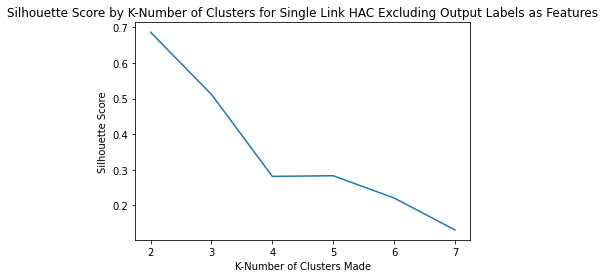

In [6]:
# Iris Classification using single-link
raw_data = loadarff('iris.arff')
df = pd.DataFrame(raw_data[0])

# Drop class for 2.1.1
df = df.drop(['class'], axis=1)
df.head()

X = df.values

# Loop from k=2 - 7 for testing
x_vals = []
sil_scores = []

for k in range(2, 8):
  hac_single = HACClustering(k=k, link_type='single')

  # Fit X on classifier with k clusters
  hac_single.fit(X)

  # Print cluster information and return silhouette score to graph
  score = hac_single.print_clusters(X)
  
  # Save k value tested and sillhouete score
  x_vals.append(k)
  sil_scores.append(score)


plt.plot(x_vals, sil_scores)
plt.xlabel("K-Number of Clusters Made")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by K-Number of Clusters for Single Link HAC Excluding Output Labels as Features")
plt.show()

Num clusters: 2
Silhouette score: -0.0470

[5.9213,3.1276,3.7535,1.1843]
127

[5.413 ,2.6478,3.787 ,1.2783]
23

Num clusters: 3
Silhouette score: -0.0913

[6.0796,3.1265,4.054 ,1.3071]
113

[4.6429,3.1357,1.3286,0.1929]
14

[5.413 ,2.6478,3.787 ,1.2783]
23

Num clusters: 4
Silhouette score: 0.2633

[5.1788,3.5939,1.5212,0.2697]
33

[4.6429,3.1357,1.3286,0.1929]
14

[5.413 ,2.6478,3.787 ,1.2783]
23

[6.4512,2.9338,5.0988,1.735 ]
80

Num clusters: 5
Silhouette score: 0.2006

[5.1788,3.5939,1.5212,0.2697]
33

[4.6429,3.1357,1.3286,0.1929]
14

[4.8   ,2.8   ,1.4667,0.2   ]
3

[6.4512,2.9338,5.0988,1.735 ]
80

[5.505,2.625,4.135,1.44 ]
20

Num clusters: 6
Silhouette score: 0.2577

[5.1788,3.5939,1.5212,0.2697]
33

[4.6429,3.1357,1.3286,0.1929]
14

[4.8   ,2.8   ,1.4667,0.2   ]
3

[6.1283,2.8109,4.5761,1.4478]
46

[5.505,2.625,4.135,1.44 ]
20

[6.8882,3.1   ,5.8059,2.1235]
34

Num clusters: 7
Silhouette score: 0.2230

[5.1788,3.5939,1.5212,0.2697]
33

[4.6429,3.1357,1.3286,0.1929]
14

[4.8  

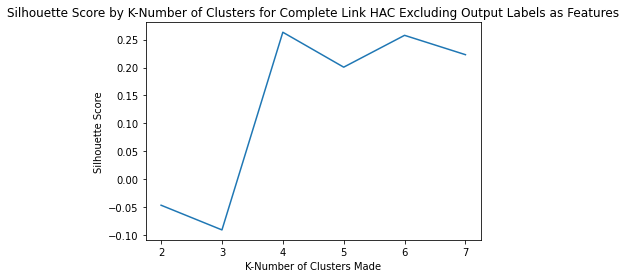

In [7]:
# Iris Classification using complete-link
raw_data = loadarff('iris.arff')
df = pd.DataFrame(raw_data[0])

# Drop class for 2.1.1
df = df.drop(['class'], axis=1)
df.head()

X = df.values

# Loop from k=2 - 7 for testing
x_vals = []
sil_scores = []

for k in range(2, 8):
  hac_complete = HACClustering(k=k, link_type='complete')

  # Fit X on classifier with k clusters
  hac_complete.fit(X)

  # Print cluster information and return silhouette score to graph
  score = hac_complete.print_clusters(X)
  
  # Save k value tested and sillhouete score
  x_vals.append(k)
  sil_scores.append(score)


plt.plot(x_vals, sil_scores)
plt.xlabel("K-Number of Clusters Made")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by K-Number of Clusters for Complete Link HAC Excluding Output Labels as Features")
plt.show()


Discuss differences between single-link and complete-link

Note: I did not normalize my data.

When I tested single link against complete link on the Iris dataset (not using the output class as a feature), I saw almost opposite results between the two methods.

With single linked clustering, the silhouette score was the highest when k = 2 and decreased on average as k increased. Even the lowest silhouette score was still positive. For complete link clustering, the trend was backwards. When k=2, there was a negative silhouette score, but it on average increased as k increased. The peak silhouette score was about the same as the lowest score for single link.

When looking at these results, it makes a bit of sense. Silhouette score measures approximately how appropriately the samples have been clustered on average across all samples. Since single link focuses on minimun connections, points get clustered more based on proximity, resulting in a couple clusters with many points and a couple very small ones. Because of this, when k is small, you get 2 larger clusters as is typical of single link, but you can expect these clusters to be quite accurate and close. However, as k increases, you start to get the lopsided clusters which hurt the silhouette score. When k = 7 in my testing this was very clear:

```
[5.0163,3.4408,1.4673,0.2429]
49

[4.5,2.3,1.3,0.3]
1

[6.288 ,2.8728,4.9326,1.6859]
92

[5.   ,2.3  ,3.275,1.025]
4

[4.9,2.5,4.5,1.7]
1

[7.2,3.6,6.1,2.5]
1

[7.8 ,3.8 ,6.55,2.1 ]
2
```

While the clusters may be close in space, the lack of dispersion of the points affects the silhouette score since there are many points that could belong to other clusters but are forced into once by the min searching nature of single link. The nature of single link makes sense that it performs better when there are less clusters to make, since it tends to create fewer, larger clusters.

With complete-link, the max search nature of it tends to favor performance when there are more clusters to make. Setting the distance between clusters to the max possible value does not work well when there are few clusters to make, as seen in my test results with the negative silhouette scores with k=2 and 3. This makes sense when thought about, since using the max distance will cause points on the edges of a cluster to be considered to be farther away than they actually are since they are part of a cluster with a couple distant points. When there are only 2 or 3 clusters to be made, points that are actually quite separated from each other get forced into the same clusters and the silhouette score decreases. As k increases however, the complete link algorithm works a lot better since it can create more even cluster sizes since it is creating more separation between the boundaries. When k = 7:

```
Num clusters: 7
Silhouette score: 0.2230

[5.1788,3.5939,1.5212,0.2697]
33

[4.6429,3.1357,1.3286,0.1929]
14

[4.8   ,2.8   ,1.4667,0.2   ]
3

[6.1283,2.8109,4.5761,1.4478]
46

[5.3417,2.4583,3.625 ,1.1333]
12

[5.75 ,2.875,4.9  ,1.9  ]
8

[6.8882,3.1   ,5.8059,2.1235]
34

```

Unlike single link which had 2 dominant clusters, there is a much more even spread of the clusters, which is controlled by the max distance considerations of complete link. With the more balanced clusters, the clusters are more robust compared to the k = 2 and 3 examples and the silhouette score increased.

From an algorithmic perspective, it makes sense why the single link silhouette score decreased as k increased and why complete link silhouette score increased as k increased.

## 2.1.2 (5%) Clustering the Iris Classification problem - HAC

Requirements:
- Repeat excercise 2.1.1 and include the output label as one of the input features.

Num clusters: 2
Silhouette score: 0.6822

[5.006,3.418,1.464,0.244,0.   ]
50

[6.262,2.872,4.906,1.676,1.5  ]
100

Num clusters: 3
Silhouette score: 0.5780

[5.006,3.418,1.464,0.244,0.   ]
50

[5.936,2.77 ,4.26 ,1.326,1.   ]
50

[6.588,2.974,5.552,2.026,2.   ]
50

Num clusters: 4
Silhouette score: 0.5199

[5.006,3.418,1.464,0.244,0.   ]
50

[5.936,2.77 ,4.26 ,1.326,1.   ]
50

[6.6224,2.9837,5.5735,2.0327,2.    ]
49

[4.9,2.5,4.5,1.7,2. ]
1

Num clusters: 5
Silhouette score: 0.4724

[5.006,3.418,1.464,0.244,0.   ]
50

[5.936,2.77 ,4.26 ,1.326,1.   ]
50

[6.5723,2.9489,5.5319,2.0298,2.    ]
47

[4.9,2.5,4.5,1.7,2. ]
1

[7.8 ,3.8 ,6.55,2.1 ,2.  ]
2

Num clusters: 6
Silhouette score: 0.4469

[5.006,3.418,1.464,0.244,0.   ]
50

[6.0174,2.8109,4.3457,1.3522,1.    ]
46

[5.   ,2.3  ,3.275,1.025,1.   ]
4

[6.5723,2.9489,5.5319,2.0298,2.    ]
47

[4.9,2.5,4.5,1.7,2. ]
1

[7.8 ,3.8 ,6.55,2.1 ,2.  ]
2

Num clusters: 7
Silhouette score: 0.3921

[5.006,3.418,1.464,0.244,0.   ]
50

[6.0174,2.8109,4.

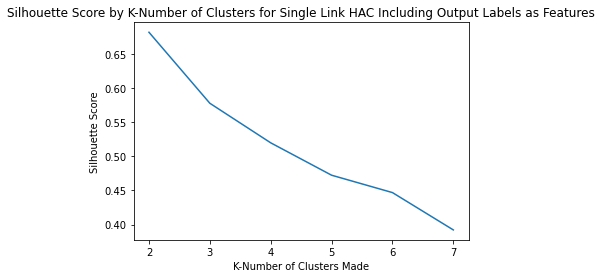

In [8]:
# Clustering Labels using single-link
raw_data = loadarff('iris.arff')
df = pd.DataFrame(raw_data[0])

# Dont drop class for 2.1.2
df['class'] = df['class'].astype('category').cat.codes
X = df.values


# Loop from k=2 - 7 for testing
x_vals = []
sil_scores = []

for k in range(2, 8):
  hac_single = HACClustering(k=k, link_type='single')

  # Fit X on classifier with k clusters
  hac_single.fit(X)

  # Print cluster information and return silhouette score to graph
  score = hac_single.print_clusters(X)
  
  # Save k value tested and sillhouete score
  x_vals.append(k)
  sil_scores.append(score)


plt.plot(x_vals, sil_scores)
plt.xlabel("K-Number of Clusters Made")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by K-Number of Clusters for Single Link HAC Including Output Labels as Features")
plt.show()

Num clusters: 2
Silhouette score: 0.1481

[6.0532,3.2468,3.9013,1.2937,1.1646]
79

[5.8474,2.7667,4.1579,1.314 ,1.0175]
57

Num clusters: 3
Silhouette score: 0.0332

[6.0532,3.2468,3.9013,1.2937,1.1646]
79

[4.6429,3.1357,1.3286,0.1929,0.    ]
14

[5.8474,2.7667,4.1579,1.314 ,1.0175]
57

Num clusters: 4
Silhouette score: 0.3739

[5.1788,3.5939,1.5212,0.2697,0.    ]
33

[4.6429,3.1357,1.3286,0.1929,0.    ]
14

[5.8474,2.7667,4.1579,1.314 ,1.0175]
57

[6.6804,2.9978,5.6087,2.0283,2.    ]
46

Num clusters: 5
Silhouette score: 0.3749

[5.1788,3.5939,1.5212,0.2697,0.    ]
33

[4.6429,3.1357,1.3286,0.1929,0.    ]
14

[4.8   ,2.8   ,1.4667,0.2   ,0.    ]
3

[5.9056,2.7648,4.3074,1.3759,1.0741]
54

[6.6804,2.9978,5.6087,2.0283,2.    ]
46

Num clusters: 6
Silhouette score: 0.3383

[5.1788,3.5939,1.5212,0.2697,0.    ]
33

[4.6429,3.1357,1.3286,0.1929,0.    ]
14

[4.8   ,2.8   ,1.4667,0.2   ,0.    ]
3

[5.9056,2.7648,4.3074,1.3759,1.0741]
54

[6.4   ,2.9529,5.3647,2.0206,2.    ]
34

[7.475,3.125,

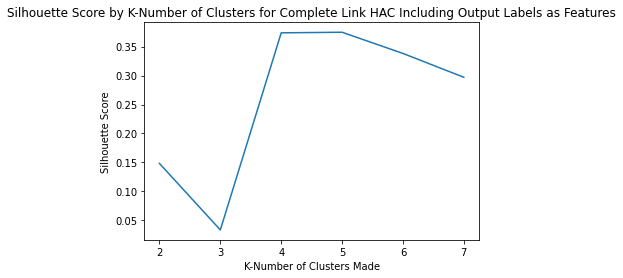

In [10]:
# Clustering Labels using complete-link
# Iris Classification using complete-link
raw_data = loadarff('iris.arff')
df = pd.DataFrame(raw_data[0])

# Drop class for 2.1.1
df['class'] = df['class'].astype('category').cat.codes
X = df.values

# Loop from k=2 - 7 for testing
x_vals = []
sil_scores = []

for k in range(2, 8):
  hac_complete = HACClustering(k=k, link_type='complete')

  # Fit X on classifier with k clusters
  hac_complete.fit(X)

  # Print cluster information and return silhouette score to graph
  score = hac_complete.print_clusters(X)
  
  # Save k value tested and sillhouete score
  x_vals.append(k)
  sil_scores.append(score)


plt.plot(x_vals, sil_scores)
plt.xlabel("K-Number of Clusters Made")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by K-Number of Clusters for Complete Link HAC Including Output Labels as Features")
plt.show()

Discuss any differences between the results from 2.1.1 and 2.1.2.

Note: I did not normalize my data.

The overall trends between 2.1.1 and 2.1.2 are the same, but there are some differences with the score when the output value is included as an input feature. The most notable is that the silhouette scores for the complete link algorithm were always positive, even when k =2 and 3, and reached about .15 higher than before. The single link results were generally the same, except the decreasing silhouette score was more smooth than before.

It makes sense why the output class as an input would help improve clustering performance. The output class was catagorized as either 0, 1 or 2 since there are three possible classes. Most of the data points as continuous data have are a lot closer spacially, since there is not much difference between 1.5 and 1.6. However, having the output features included which introduce distances as large as 2 (class 0 vs. class 2) add a new dimension of distances between points which are very pronounced. Since the single link is just connecting the mins, this extra dimension does not change the smallest distances all that much, resulting in similar clusters than before. When using the max distances between clusters like in complete link, that extra dimension of large distances can and does make a difference in separation. This more clear separation allows the complete link algorithm to make better clusters than before when the output class wa snot included.

## 2.2.1 (7.5%) Clustering the Iris Classification problem: K-Means

Load the Iris Dataset [Iris Dataset](https://byu.instructure.com/courses/14142/files?preview=4421369)

Run K-Means on the Iris dataset using the output label as a feature and without using the output label as a feature

Requirements:
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the silhouette score for each k and discuss your results (i.e. what kind of clusters are being made).
---

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)
/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)
/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant 

Num clusters: 2
Silhouette score: 0.6808

[6.301 ,2.8866,4.9588,1.6959]
97

[5.0057,3.3604,1.5623,0.2887]
53

Num clusters: 3
Silhouette score: 0.5510

[6.8538,3.0769,5.7154,2.0538]
39

[5.8836,2.741 ,4.3885,1.4344]
61

[5.006,3.418,1.464,0.244]
50

Num clusters: 4
Silhouette score: 0.4972

[6.9125,3.1   ,5.8469,2.1312]
32

[6.2366,2.8585,4.8073,1.622 ]
41

[5.006,3.418,1.464,0.244]
50

[5.5296,2.6222,3.9407,1.2185]
27

Num clusters: 5
Silhouette score: 0.3760

[6.9125,3.1   ,5.8469,2.1312]
32

[6.2366,2.8585,4.8073,1.622 ]
41

[4.713 ,3.1217,1.4174,0.1913]
23

[5.5296,2.6222,3.9407,1.2185]
27

[5.2556,3.6704,1.5037,0.2889]
27

Num clusters: 6
Silhouette score: 0.3703

[5.1375,3.4562,1.4812,0.2938]
16

[4.8143,3.0714,1.5   ,0.1857]
14

[4.5   ,3.1875,1.275 ,0.2   ]
8

[5.8836,2.741 ,4.3885,1.4344]
61

[5.3917,3.925 ,1.525 ,0.275 ]
12

[6.8538,3.0769,5.7154,2.0538]
39

Num clusters: 7
Silhouette score: 0.3742

[5.1176,3.4529,1.5059,0.2882]
17

[4.8154,3.1   ,1.4538,0.1769]
13

[4.4 ,2.8

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)


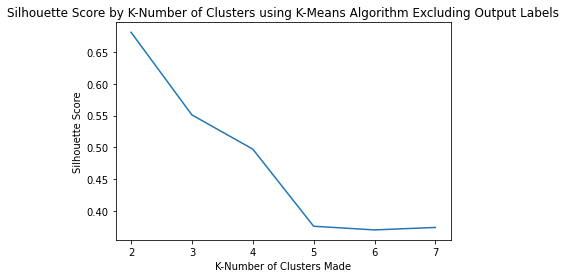

In [12]:
# Iris Classification without output label
raw_data = loadarff('iris.arff')
df = pd.DataFrame(raw_data[0])

# Drop class for 2.2.1
df = df.drop(['class'], axis=1)
X = df.values

# Loop from k=2 - 7 for testing
x_vals = []
sil_scores = []

for k in range(2, 8):
  k_means = KMEANSClustering(k=k, debug=True)

  # Fit X on classifier with k clusters
  k_means.fit(X)

  # Print cluster information and return silhouette score to graph
  score = k_means.print_clusters(X)
  
  # Save k value tested and sillhouete score
  x_vals.append(k)
  sil_scores.append(score)


plt.plot(x_vals, sil_scores)
plt.xlabel("K-Number of Clusters Made")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by K-Number of Clusters using K-Means Algorithm Excluding Output Labels")
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)
/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)
/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant 

Num clusters: 2
Silhouette score: 0.6761

[6.2878,2.8806,4.9418,1.6888,1.5102]
98

[5.0058,3.3808,1.5288,0.275 ,0.0385]
52

Num clusters: 3
Silhouette score: 0.5790

[6.624,2.984,5.562,2.026,1.98 ]
50

[5.9  ,2.76 ,4.25 ,1.326,1.02 ]
50

[5.006,3.418,1.464,0.244,0.   ]
50

Num clusters: 4
Silhouette score: 0.5056

[6.6224,2.9837,5.5735,2.0327,2.    ]
49

[6.3   ,2.9185,4.5852,1.4519,1.    ]
27

[5.006,3.418,1.464,0.244,0.   ]
50

[5.4833,2.5917,3.9042,1.2   ,1.0417]
24

Num clusters: 5
Silhouette score: 0.3807

[6.6224,2.9837,5.5735,2.0327,2.    ]
49

[6.3   ,2.9185,4.5852,1.4519,1.    ]
27

[4.713 ,3.1217,1.4174,0.1913,0.    ]
23

[5.4833,2.5917,3.9042,1.2   ,1.0417]
24

[5.2556,3.6704,1.5037,0.2889,0.    ]
27

Num clusters: 6
Silhouette score: 0.3988

[5.1375,3.4562,1.4812,0.2938,0.    ]
16

[4.8143,3.0714,1.5   ,0.1857,0.    ]
14

[4.5   ,3.1875,1.275 ,0.2   ,0.    ]
8

[5.9  ,2.76 ,4.25 ,1.326,1.02 ]
50

[5.3917,3.925 ,1.525 ,0.275 ,0.    ]
12

[6.624,2.984,5.562,2.026,1.98 ]
50

N

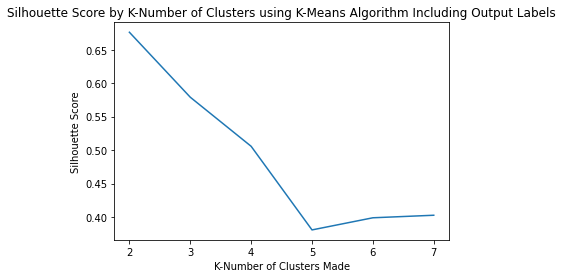

In [13]:
# Iris Classification with output label
raw_data = loadarff('iris.arff')
df = pd.DataFrame(raw_data[0])

# Don't drop class
df['class'] = df['class'].astype('category').cat.codes
X = df.values

# Loop from k=2 - 7 for testing
x_vals = []
sil_scores = []

for k in range(2, 8):
  k_means = KMEANSClustering(k=k, debug=True)

  # Fit X on classifier with k clusters
  k_means.fit(X)

  # Print cluster information and return silhouette score to graph
  score = k_means.print_clusters(X)
  
  # Save k value tested and sillhouete score
  x_vals.append(k)
  sil_scores.append(score)


plt.plot(x_vals, sil_scores)
plt.xlabel("K-Number of Clusters Made")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by K-Number of Clusters using K-Means Algorithm Including Output Labels")
plt.show()

Compare results and differences between using the output label and excluding the output label

Note: I did not normalize data.

Unlike in the HAC testing section, there was less of a noticable difference between the inclusion/exclusion of the output features when using my K-Means algorithm. That is not to say there was no difference. 

In both cases, the algorithm reached an approximate minimum silhouette score at around k = 5. When the output labels were not included, the silhouette score stagnated at around the same value as k approached 7. However, when the output was included, there was a small bump up in the silhouette score after k = 5. While it is not much of a gain, the extra dimension the output provided in calculating distances helped to at least provide some more separation that was preserved with more clusters.

In general, it makes sense to see the silhouette score as cluster number increases. In the iris dataset, there are only 3 output classes. Since there is natural separation between the points, the algorithm should perform best when it is identifying the natural division between points. This is the same for if the output is included as an input or not; the output just adds more distance between points, but the overall clustering is similar, which is reflected in the silhouette scores in the two examples. Once the number of clusters exceeds the number of output classes, the algorithm starts to struggle and has to create clusters with more overlap since the points are actually not in the same class in the dataset. This effect only gets worse with the increase in k, although the inclusion of the output features at least appears to alievate the effect a little bit at some of the higher k values.

Although there was not so much a pronounced difference between the inclusion and exclusion of the output labels in the data, the overall trends seen in both experiments makes sense in the context of the dataset.

## 2.2.2 (5%) Clustering the Iris Classification problem: K-Means

Requirements:
- Use the output label as an input feature
- Run K-Means 5 times with k=4, each time with different initial random centroids and discuss any variations in the results. 

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)
/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)
/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2440: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant 

Num clusters: 4
Silhouette score: 0.5056

[6.3   ,2.9185,4.5852,1.4519,1.    ]
27

[6.6224,2.9837,5.5735,2.0327,2.    ]
49

[5.4833,2.5917,3.9042,1.2   ,1.0417]
24

[5.006,3.418,1.464,0.244,0.   ]
50

Num clusters: 4
Silhouette score: 0.4458

[4.725 ,3.1333,1.4208,0.1917,0.    ]
24

[6.6224,2.9837,5.5735,2.0327,2.    ]
49

[5.9157,2.7647,4.2647,1.3333,1.0196]
51

[5.2654,3.6808,1.5038,0.2923,0.    ]
26

Num clusters: 4
Silhouette score: 0.4991

[6.3   ,2.897 ,5.1394,1.8727,1.8182]
33

[5.006,3.418,1.464,0.244,0.   ]
50

[7.1227,3.1136,6.0318,2.1318,2.    ]
22

[5.8133,2.7356,4.1844,1.3089,1.0222]
45

Num clusters: 4
Silhouette score: 0.5385

[5.006,3.418,1.464,0.244,0.   ]
50

[5.9  ,2.76 ,4.25 ,1.326,1.02 ]
50

[6.3278,2.925 ,5.3028,2.0028,1.9722]
36

[7.3857,3.1357,6.2286,2.0857,2.    ]
14

Num clusters: 4
Silhouette score: 0.4452

[4.713 ,3.1217,1.4174,0.1913,0.    ]
23

[5.2556,3.6704,1.5037,0.2889,0.    ]
27

[6.624,2.984,5.562,2.026,1.98 ]
50

[5.9  ,2.76 ,4.25 ,1.326,1.02 ]
50



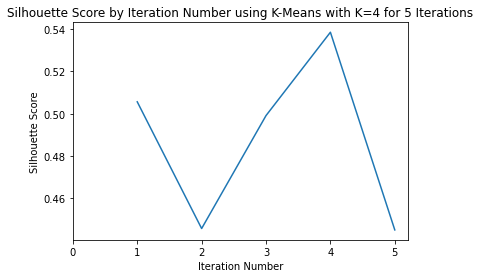

In [14]:
#K-Means 5 times
# Iris Classification with output label
raw_data = loadarff('iris.arff')
df = pd.DataFrame(raw_data[0])

# Don't drop class
df['class'] = df['class'].astype('category').cat.codes
X = df.values

# Loop from k=2 - 7 for testing
x_vals = []
sil_scores = []

for i in range(5):
  k_means = KMEANSClustering(k=4, debug=False)

  # Fit X on classifier with k clusters
  k_means.fit(X)

  # Print cluster information and return silhouette score to graph
  score = k_means.print_clusters(X)
  
  # Save k value tested and sillhouete score
  x_vals.append(i+1)
  sil_scores.append(score)


plt.plot(x_vals, sil_scores)
plt.xticks(np.arange(0, len(x_vals)+1))
plt.xlabel("Iteration Number")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by Iteration Number using K-Means with K=4 for 5 Iterations")
plt.show()

In [15]:
print("Average Silhouette Score: ", np.mean(sil_scores))

Average Silhouette Score:  0.4868328314101788


Discuss any variations in the results

Note: I did not normalize my data.

The end result was not too surprising given my previous results with the iris dataset. 

When using the first k entries as centroid in the previous section, my silhouette score was 0.5056. In the 5 tests I ran here, silhouette scores bounced around between about 0.45 and 0.55, with a 5 test average of about 0.4868. Given the closeness of this 5-test average and the determinstic result of 0.5056, it seems fair to say that the random results are showing an appropriate amount of variance. The average falls close to the deterministic result, but there are clearly better starting points than others, as seen by the fact that my max test score was higher than the deterministic silhouette score.

I ran the code multiple times and saw similar results, but it would be interesting and beneficial to run it more iterations to try and find the max silhouette score and save the starting centroids so it can be recorded and recreated. With any algorithm that uses random elements, it is always best to try it multiple times as a form of parameter search, in order to optimize prediction performance.

## 3.1 (12.5%) Run the SK versions of HAC (both single and complete link) on iris including the output label and compare your results with those above.
Use the silhouette score for this iris problem(k = 2-7).  You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) and compare the results. State which metric was used. 
- Possible sklean metrics include (* metrics require ground truth labels):
    - adjusted_mutual_info_score*
    - adjusted_rand_score*
    - homogeneity_score*
    - completeness_score*
    - fowlkes_mallows_score*
    - calinski_harabasz_score
    - davies_bouldin_score
- Experiment using different hyper-parameters. Discuss Results

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score

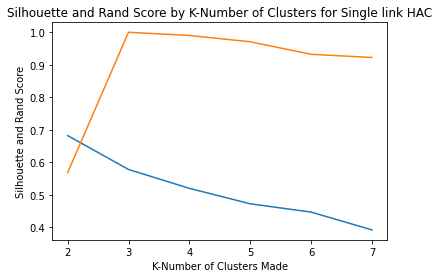

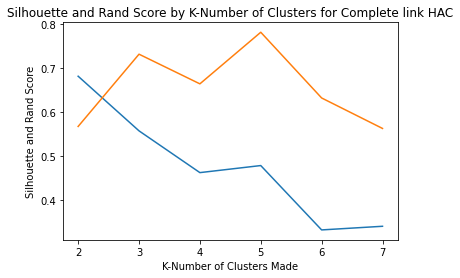


Silhouette score with k=5, single-link, default parameters:  0.4724098009577553
Rand score with k=5, single-link, default parameters:  0.9707203586058675

Silhouette score with k=5, single-link, manhattan distance:  0.396084066910592
Rand score with k=5, single-link, manhattan distance:  0.9802028071934503

Silhouette score with k=5, single-link, affinity=l1:  0.396084066910592
Rand score with k=5, single-link, affinity=l1:  0.9802028071934503

Silhouette score with k=5, single-link, affinity=l2:  0.4724098009577553
Rand score with k=5, single-link, affinity=l2:  0.9707203586058675

Silhouette score with k=5, single-link, affinity=cosine:  0.23505472791139156
Rand score with k=5, single-link, affinity=cosine:  0.9799973150758491


In [ ]:
# Load iris data keep output class
raw_data = loadarff('iris.arff')
df = pd.DataFrame(raw_data[0])

# Don't drop class
df['class'] = df['class'].astype('category').cat.codes
ground_truth = df['class']
X = df.values

# Initialize values to graph
x_vals = []
sil_scores = []
adjusted_rand_scores = []

# Run normal testing using base parameters and k=2-7 and single link
for k in range(2,8):
  clustering = AgglomerativeClustering(n_clusters=k,linkage='single')
  clusters = clustering.fit_predict(X)

  sil_score = silhouette_score(X, clusters)
  rand_score = adjusted_rand_score(ground_truth, clusters)

  x_vals.append(k)
  sil_scores.append(sil_score)
  adjusted_rand_scores.append(rand_score)

plt.plot(x_vals, sil_scores)
plt.plot(x_vals, adjusted_rand_scores)
plt.xlabel("K-Number of Clusters Made")
plt.ylabel("Silhouette and Rand Score")
plt.title("Silhouette and Rand Score by K-Number of Clusters for Single link HAC")
plt.show()


# Save silhouette score for single link at k=5 for parameter testing reference
test_sil = sil_scores[3]
test_rand = adjusted_rand_scores[3]

x_vals = []
sil_scores = []
adjusted_rand_scores = []
# Run normal testing using base parameters and k=2-7 and single link
for k in range(2,8):
  clustering = AgglomerativeClustering(n_clusters=k,linkage='complete')
  clusters = clustering.fit_predict(X)

  sil_score = silhouette_score(X, clusters)
  rand_score = adjusted_rand_score(ground_truth, clusters)

  x_vals.append(k)
  sil_scores.append(sil_score)
  adjusted_rand_scores.append(rand_score)

plt.plot(x_vals, sil_scores)
plt.plot(x_vals, adjusted_rand_scores)
plt.xlabel("K-Number of Clusters Made")
plt.ylabel("Silhouette and Rand Score")
plt.title("Silhouette and Rand Score by K-Number of Clusters for Complete link HAC")
plt.show()

print("\nSilhouette score with k=5, single-link, default parameters: ", test_sil)
print("Rand score with k=5, single-link, default parameters: ", test_rand)
# Test clustering with some different parameters, k=5 as baseline

# Test with k = 5, single link manhatten distance
clustering = AgglomerativeClustering(n_clusters=5, linkage='single', affinity='manhattan')
clusters = clustering.fit_predict(X)

sil_score = silhouette_score(X, clusters)
rand_score = adjusted_rand_score(ground_truth, clusters)
print("\nSilhouette score with k=5, single-link, manhattan distance: ", sil_score)
print("Rand score with k=5, single-link, manhattan distance: ", rand_score)

# test with k=5, single link, affinity=l1
clustering = AgglomerativeClustering(n_clusters=5, linkage='single', affinity='l1')
clusters = clustering.fit_predict(X)

sil_score = silhouette_score(X, clusters)
rand_score = adjusted_rand_score(ground_truth, clusters)
print("\nSilhouette score with k=5, single-link, affinity=l1: ", sil_score)
print("Rand score with k=5, single-link, affinity=l1: ", rand_score)

# test with k=5, single link, affinity=l2
clustering = AgglomerativeClustering(n_clusters=5, linkage='single', affinity='l2')
clusters = clustering.fit_predict(X)

sil_score = silhouette_score(X, clusters)
rand_score = adjusted_rand_score(ground_truth, clusters)
print("\nSilhouette score with k=5, single-link, affinity=l2: ", sil_score)
print("Rand score with k=5, single-link, affinity=l2: ", rand_score)

# test with k=5, single link, affinity=cosine
clustering = AgglomerativeClustering(n_clusters=5, linkage='single', affinity='cosine')
clusters = clustering.fit_predict(X)

sil_score = silhouette_score(X, clusters)
rand_score = adjusted_rand_score(ground_truth, clusters)
print("\nSilhouette score with k=5, single-link, affinity=cosine: ", sil_score)
print("Rand score with k=5, single-link, affinity=cosine: ", rand_score)

*Record impressions*

The results of single link and complete link for the sklearn clustering models were overall pretty similar which surprised me. Just looking at the silhouette score, it would be hard to determine a best way to cluster this dataset. I also used the adjusted rand score from sklearn.metrics to evaluate the performance and that gave a more interesting picture. For single link, after K=3, the algorithm scored quite high and close to 1 and stayed consistently in that area, but for complete link, rand score varied all over the place. Rand score calculates a similarity metric between all samples between different clusters and scores how similar all the points within a cluster are. This would indicate that the single link model does a better job of clustering similar datapoints than the complete link one does, which matches up with what we know about the two methods (single focuses on closer distance, complete focuses on more even clusters). Having this extra metric makes it easier to tell which approach is better for this dataset.

Playing with the parameters also gave a few variations on what could be done to improve performance. I used k = 5 as a standard testing number of clusters and used single link based on the initial test results. Overall, from the parameter testing, using almost any different distance metric improved the rand score, but decreased the silhouette score of the output. The decrease in silhouette score was significant enough that it seemed like the original method of running it with the default parameters was the best way as it produced the best silhouette score with a still very high rand score.

## 3.2 (12.5%) Run the SK version of k-means on iris including the output label and compare your results with those above. 

Use the silhouette score for this iris problem(k = 2-7). You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function form sklearn.metrics and compare the results. State which metric was used
- Experiment different hyper-parameters. Discuss Results

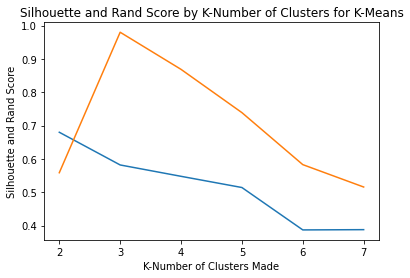


Silhouette score with k=5, default parameters:  0.5139872287357489
Rand score with k=5, default parameters:  0.7387204521717036

Silhouette score with k=5, k-means++ init:  0.5139872287357489
Rand score with k=5, k-means++ init:  0.7387204521717036

Silhouette score with k=5, init=random:  0.5212789403470786
Rand score with k=5, init=random:  0.7441028748162791

Silhouette score with k=5, init=random, n_init=50:  0.5187741145336747
Rand score with k=5, init=random, n_init=50:  0.7388385111419234

Silhouette score with k=5, init=random, algorithm=elkan:  0.513434940880452
Rand score with k=5, init=random, algorithm=elkan:  0.7396401546203691

Silhouette score with k=5, init=random, algorithm=elkan, max_iter=150:  0.513434940880452
Rand score with k=5, init=random, algorithm=elkan, max_iter=150:  0.7396401546203691

Silhouette score with k=5, init=random, algorithm=elkan, max_iter=500:  0.5187741145336747
Rand score with k=5, init=random, algorithm=elkan, max_iter=500:  0.73883851114192

In [ ]:
# Load sklearn 
# Load iris data keep output class
raw_data = loadarff('iris.arff')
df = pd.DataFrame(raw_data[0])

# Don't drop class
df['class'] = df['class'].astype('category').cat.codes
ground_truth = df['class']
X = df.values

# Initialize values to graph
x_vals = []
sil_scores = []
adjusted_rand_scores = []

# Run normal testing using base parameters and k=2-7 and single link
for k in range(2,8):
  clustering = KMeans(n_clusters=k)
  clusters = clustering.fit_predict(X)

  sil_score = silhouette_score(X, clusters)
  rand_score = adjusted_rand_score(ground_truth, clusters)

  x_vals.append(k)
  sil_scores.append(sil_score)
  adjusted_rand_scores.append(rand_score)

plt.plot(x_vals, sil_scores)
plt.plot(x_vals, adjusted_rand_scores)
plt.xlabel("K-Number of Clusters Made")
plt.ylabel("Silhouette and Rand Score")
plt.title("Silhouette and Rand Score by K-Number of Clusters for K-Means")
plt.show()

# Save silhouette score for single link at k=5 for parameter testing reference
test_sil = sil_scores[3]
test_rand = adjusted_rand_scores[3]

# Print k=5 comparison scores to compare when changing parameters
print("\nSilhouette score with k=5, default parameters: ", test_sil)
print("Rand score with k=5, default parameters: ", test_rand)

# Test clustering with some different parameters, k=5 as baseline

# Test with k = 5, init=k-means++
clustering = KMeans(n_clusters=5, init='k-means++')
clusters = clustering.fit_predict(X)

sil_score = silhouette_score(X, clusters)
rand_score = adjusted_rand_score(ground_truth, clusters)
print("\nSilhouette score with k=5, k-means++ init: ", sil_score)
print("Rand score with k=5, k-means++ init: ", rand_score)

# test with k=5 init=random
clustering = KMeans(n_clusters=5, init='random')
clusters = clustering.fit_predict(X)

sil_score = silhouette_score(X, clusters)
rand_score = adjusted_rand_score(ground_truth, clusters)
print("\nSilhouette score with k=5, init=random: ", sil_score)
print("Rand score with k=5, init=random: ", rand_score)

# test with k=5 init=random, n_init=50
clustering = KMeans(n_clusters=5, init='random', n_init=50)
clusters = clustering.fit_predict(X)

sil_score = silhouette_score(X, clusters)
rand_score = adjusted_rand_score(ground_truth, clusters)
print("\nSilhouette score with k=5, init=random, n_init=50: ", sil_score)
print("Rand score with k=5, init=random, n_init=50: ", rand_score)


# test with k=5 init=random, algorithm = elkan
clustering = KMeans(n_clusters=5, init='random', algorithm='elkan')
clusters = clustering.fit_predict(X)

sil_score = silhouette_score(X, clusters)
rand_score = adjusted_rand_score(ground_truth, clusters)
print("\nSilhouette score with k=5, init=random, algorithm=elkan: ", sil_score)
print("Rand score with k=5, init=random, algorithm=elkan: ", rand_score)

# test with k=5 init=random, algorithm = elkan, max_iter=150
clustering = KMeans(n_clusters=5, init='random', algorithm='elkan', max_iter=150)
clusters = clustering.fit_predict(X)

sil_score = silhouette_score(X, clusters)
rand_score = adjusted_rand_score(ground_truth, clusters)
print("\nSilhouette score with k=5, init=random, algorithm=elkan, max_iter=150: ", sil_score)
print("Rand score with k=5, init=random, algorithm=elkan, max_iter=150: ", rand_score)

# test with k=5 init=random, algorithm = elkan, max_iter=500
# High max iter probably won't do anything for this dataset but wanted to try anyways.
clustering = KMeans(n_clusters=5, init='random', algorithm='elkan', max_iter=500)
clusters = clustering.fit_predict(X)

sil_score = silhouette_score(X, clusters)
rand_score = adjusted_rand_score(ground_truth, clusters)
print("\nSilhouette score with k=5, init=random, algorithm=elkan, max_iter=500: ", sil_score)
print("Rand score with k=5, init=random, algorithm=elkan, max_iter=500: ", rand_score)

*Record impressions*

The K-Means testing with the sklearn model produced some very clear results as to the best way to classify the data. As before, silhouette score decreasd as k decreased and the scores were similar to my model's output. However, the rand score shows a very obvious case of what number k is the best. The rand score was decent when k = 2 and decreased from k = 4, but peaked at k = 3. This makes sense; if rand score is trying to measure how similar data points within a cluster are to each other, it would make sense that the points will be most similar when the number of clusters is equal to the actual number of output classes. That way, each cluster is generally consisting of points of the same class, so the data will be the most similar. These results made it very clear that for the iris dataset, the best way to cluster it is with k = 3. 

After playing with the parameters (again, I used k = 5 for an standard comparison), there was not a lot to change either the silhouette score or the rand score. One thing that did improve silhouette score slightly was changing the init parameter from k-means++ (Sklearns 'smart' centroid selection method) to a random selection. The gain was not large, but 0.01 improvement is always worth noting at least. These settings also provided the best rand score, which also had about a 0.01 increase over the default settings. Some other small settings provided very small increases such as using the Elkan algorithm opposed to the default, but for the most part, there was no one parameter that significantly changed the results over the default settings.